In [1]:
# Standard libraries
import h5py
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
libpath = os.path.join(path1p, "lib")

sys.path.insert(0, libpath) 
print("Appended library directory", libpath)

# User libraries
from models.test_lib import noisePure, noiseLPF, sampleTrials
from models.dyn_sys import DynSys

from fc.te_idtxl_wrapper import idtxlParallelCPU, idtxlResultsParse

%load_ext autoreload
%autoreload 2

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Appended library directory /media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-mesoscopic/mesoscopic-functional-connectivity/codes/lib


In [2]:
def matdiff(m1, m2):
    TP = FP = FN = TN = 0
    for i in range(m1.shape[0]):
        for j in range(m1.shape[1]):
            NAN1 = np.isnan(m1[i, j])
            NAN2 = np.isnan(m2[i, j])
            TP += (not NAN1) and (not NAN2)
            FP += (not NAN1) and (NAN2)
            FN += (NAN1) and (not NAN2)
            TN += (NAN1) and (NAN2)
            
    T1 = FP / (FP + TP) if FP + TP != 0 else 0
    T2 = FN / (FN + TN) if FN + TN != 0 else 0
    FP_RATE = FP / np.prod(m1.shape)
    FN_RATE = FN / np.prod(m1.shape)
            
    return TP,FP,FN,TN,T1,T2,FP_RATE,FN_RATE

def testplots(ndata, te_data_combo, TRUE_CONN, logx=True, pfilter=None, h5_fname=None, fig_fname=None):
    te_3D, lag_3D, p_3D = te_data_combo
    
    #####################################
    # Save data
    #####################################
    if h5_fname is not None:
        with h5py.File(h5_fname, "w") as h5f:
            grp_rez = h5f.create_group("results")
            grp_rez['TE_table'] = te_3D
            grp_rez['delay_table'] = lag_3D
            grp_rez['p_table'] = p_3D
    
    #####################################
    # Analysis
    #####################################
    
    # Copy data to avoid modifying originals
    te, lag, p = np.copy(te_3D), np.copy(lag_3D), np.copy(p_3D)
    NSTEP = te.shape[2]
    
    # Delete all connections that have too high p-value, if requested
    if pfilter is not None:
        # Find which non-nan entries of p-value need to be filtered
        mask = ~np.isnan(p)
        mask[mask] &= p[mask] > pfilter
        
        # Set those entries to nan
        te[mask] = np.nan
        lag[mask] = np.nan
        p[mask] = np.nan
    
    # Compute statistics
    test_fp = np.array([matdiff(te[:, :, i], TRUE_CONN) for i in range(NSTEP)]).transpose()
    freq_conn = NSTEP - np.sum(np.isnan(te), axis=2)
    
    #####################################
    # Plots
    #####################################
    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(15,10))
    ax[0][0].set_title("Error rates")
    if logx:
        #ax[0][0].semilogx(ndata, test_fp[4], label='T1')
        #ax[0][0].semilogx(ndata, test_fp[5], label='T2')
        ax[0][0].semilogx(ndata, test_fp[6], '.-', label='FP_RATE')
        ax[0][0].semilogx(ndata, test_fp[7], '.-', label='FN_RATE')
    else:
        #ax[0][0].plot(ndata, test_fp[4], label='T1')
        #ax[0][0].plot(ndata, test_fp[5], label='T2')
        ax[0][0].plot(ndata, test_fp[6], '.-', label='FP_RATE')
        ax[0][0].plot(ndata, test_fp[7], '.-', label='FN_RATE')
    ax[0][0].legend()
    
    ax[0][1].set_title("True connections")
    ax[0][1].imshow(TRUE_CONN)
    
    ax[1][1].set_title("Frequencies of connections")
    ax[1][1].imshow(freq_conn, vmin=0, vmax=NSTEP)
    
    ax[1][0].set_title("TE for each connection")
    ax[1][2].set_title("p for each connection")
    ax[0][2].set_title("lag for each connection")
    ax[0][2].set_yticks(list(range(1, int(np.nanmax(lag))+1)))
    for i in range(model_param['N_NODE']):
        for j in range(model_param['N_NODE']):
            if logx:
                ax[1][0].loglog(ndata, te[i, j, :], '.-')
                ax[1][2].loglog(ndata, p[i, j, :], '.-')
                ax[0][2].semilogx(ndata, lag[i, j, :], '.-')
            else:
                ax[1][0].semilogy(ndata, te[i, j, :], '.-')
                ax[1][2].semilogy(ndata, p[i, j, :], '.-')
                ax[0][2].plot(ndata, lag[i, j, :], '.-')
    
    if fig_fname is not None:
        plt.savefig(fig_fname, dpi=300)
        
    plt.show()

## 1. Pure noise - Timestep Test

In [3]:
def DynSys_func(param):
    DS = DynSys(param)
    DS.compute()
    return np.copy(DS.data)

idtxl_settings = {
    'dim_order'       : 'ps',
    'method'          : 'MultivariateTE',
    'cmi_estimator'   : 'JidtGaussianCMI',
    'max_lag_sources' : 5,
    'min_lag_sources' : 1}

# Set parameters
model_param_noisepure = {
    'method'      : noisePure,
    'N_NODE'      : 12,             # Number of channels 
    'T_TOT'       : 10,             # seconds, Total simulation time
    'DT'          : 0.2,            # seconds, Binned optical recording resolution
    'STD'         : 1               # Standard deviation of random data
}

# Set parameters
model_param_lpfsub = {
    'method'      : noiseLPF,
    'N_NODE'      : 12,             # Number of channels 
    'T_TOT'       : 10,             # seconds, Total simulation time
    'TAU_CONV'    : 0.5,            # seconds, Ca indicator decay constant
    'DT_MICRO'    : 0.001,          # seconds, Neuronal spike timing resolution
    'DT'          : 0.2,            # seconds, Binned optical recording resolution
    'STD'         : 1               # Standard deviation of random data
}

# Set parameters
model_param_dynsys = {
    'method'  : DynSys_func,
    'ALPHA'   : 0.1,  # 1-connectivity strength
    'N_NODE'  : 12,   # Number of variables
    'N_DATA'  : 4000, # Number of timesteps
    'MAG'     : 0.0,    # Magnitude of input
    'T'       : 20,   # Period of input oscillation
    'STD'     : 0.2   # STD of neuron noise
}

model_param_all = {
    "purenoise"   : model_param_noisepure,
    "lpfsubnoise" : model_param_lpfsub,
    "dynsys"      : model_param_dynsys
}

# True connectivity matrix for this problem
DS_TMP = DynSys(model_param_dynsys)
TRUE_CONN_DS = DS_TMP.M.transpose()
TRUE_CONN_DS[TRUE_CONN_DS == 0] = np.nan
TRUE_CONN_DICT = {
    "purenoise"   : np.full((N_NODE, N_NODE), np.nan),
    "lpfsubnoise" : np.full((N_NODE, N_NODE), np.nan),
    "dynsys"   :    TRUE_CONN_DS
}

Generating Data width purenoise 79
Generating Data width purenoise 85
Generating Data width purenoise 92
Generating Data width purenoise 100
Generating Data width purenoise 108
Generating Data width purenoise 116
Generating Data width purenoise 126
Generating Data width purenoise 136
Generating Data width purenoise 147
Generating Data width purenoise 158
Generating Data width purenoise 171
Generating Data width purenoise 185
Generating Data width purenoise 200
Generating Data width purenoise 215
Generating Data width purenoise 233
Generating Data width purenoise 251
Generating Data width purenoise 271
Generating Data width purenoise 293
Generating Data width purenoise 316
Generating Data width purenoise 342
Generating Data width purenoise 369
Generating Data width purenoise 399
Generating Data width purenoise 430
Generating Data width purenoise 465
Generating Data width purenoise 502
Generating Data width purenoise 542
Generating Data width purenoise 585
Generating Data width purenoise

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/numpy/ma/core.py:715: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)
/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


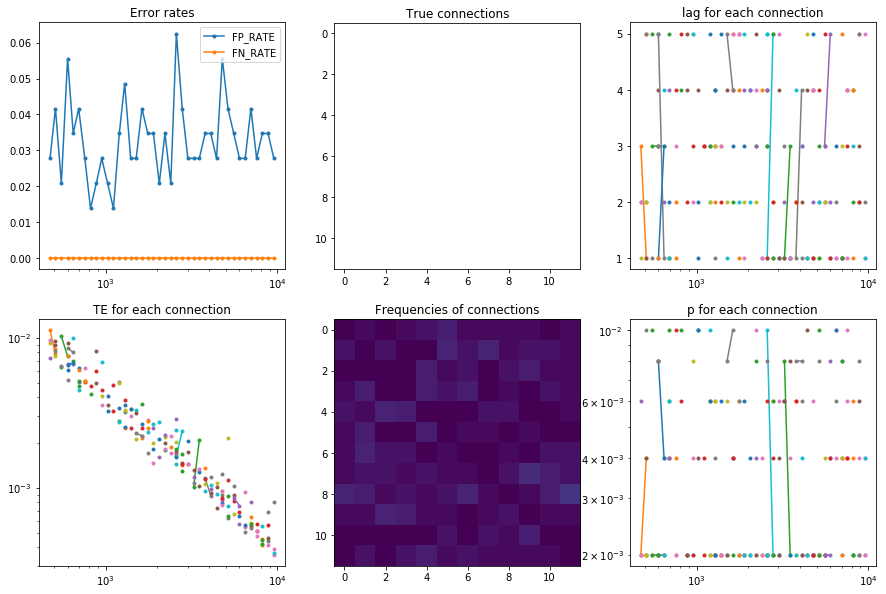

Processing Data width MultivariateMI purenoise 79
Adding data with properties: 12 processes, 474 samples, 1 replications
overwriting existing data
Processing Data width MultivariateMI purenoise 85
Adding data with properties: 12 processes, 510 samples, 1 replications
overwriting existing data
Processing Data width MultivariateMI purenoise 92
Adding data with properties: 12 processes, 552 samples, 1 replications
overwriting existing data
Processing Data width MultivariateMI purenoise 100
Adding data with properties: 12 processes, 600 samples, 1 replications
overwriting existing data
Processing Data width MultivariateMI purenoise 108
Adding data with properties: 12 processes, 647 samples, 1 replications
overwriting existing data
Processing Data width MultivariateMI purenoise 116
Adding data with properties: 12 processes, 696 samples, 1 replications
overwriting existing data
Processing Data width MultivariateMI purenoise 126
Adding data with properties: 12 processes, 756 samples, 1 replic

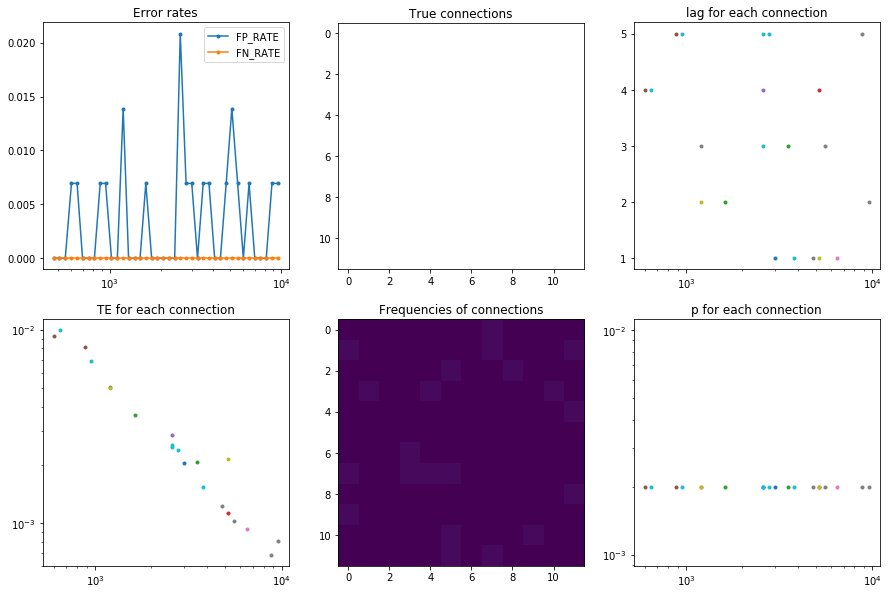

Processing Data width BivariateTE purenoise 79
Adding data with properties: 12 processes, 474 samples, 1 replications
overwriting existing data
Processing Data width BivariateTE purenoise 85
Adding data with properties: 12 processes, 510 samples, 1 replications
overwriting existing data
Processing Data width BivariateTE purenoise 92
Adding data with properties: 12 processes, 552 samples, 1 replications
overwriting existing data
Processing Data width BivariateTE purenoise 100
Adding data with properties: 12 processes, 600 samples, 1 replications
overwriting existing data
Processing Data width BivariateTE purenoise 108
Adding data with properties: 12 processes, 647 samples, 1 replications
overwriting existing data
Processing Data width BivariateTE purenoise 116
Adding data with properties: 12 processes, 696 samples, 1 replications
overwriting existing data
Processing Data width BivariateTE purenoise 126
Adding data with properties: 12 processes, 756 samples, 1 replications
overwriting ex

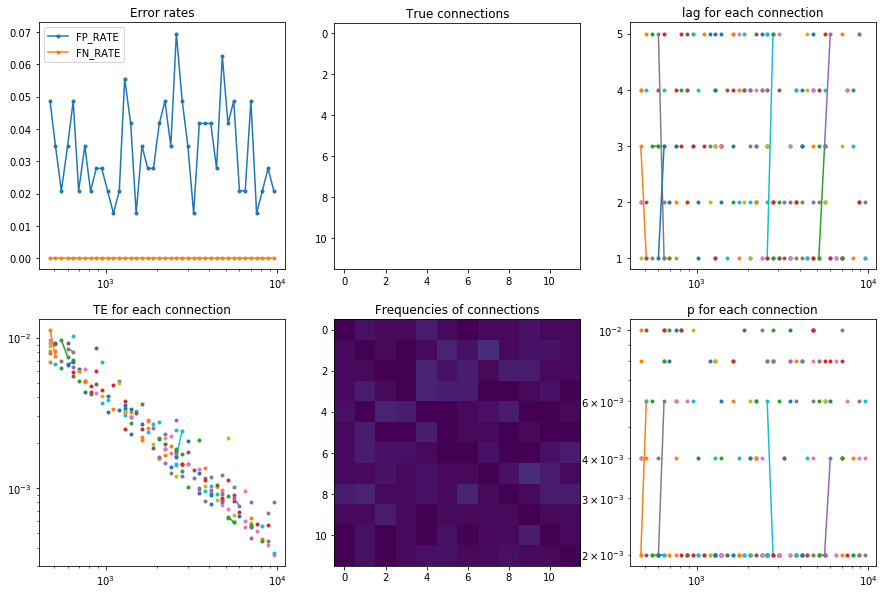

Processing Data width MultivariateTE purenoise 79
Adding data with properties: 12 processes, 474 samples, 1 replications
overwriting existing data
Processing Data width MultivariateTE purenoise 85
Adding data with properties: 12 processes, 510 samples, 1 replications
overwriting existing data
Processing Data width MultivariateTE purenoise 92
Adding data with properties: 12 processes, 552 samples, 1 replications
overwriting existing data
Processing Data width MultivariateTE purenoise 100
Adding data with properties: 12 processes, 600 samples, 1 replications
overwriting existing data
Processing Data width MultivariateTE purenoise 108
Adding data with properties: 12 processes, 647 samples, 1 replications
overwriting existing data
Processing Data width MultivariateTE purenoise 116
Adding data with properties: 12 processes, 696 samples, 1 replications
overwriting existing data
Processing Data width MultivariateTE purenoise 126
Adding data with properties: 12 processes, 756 samples, 1 replic

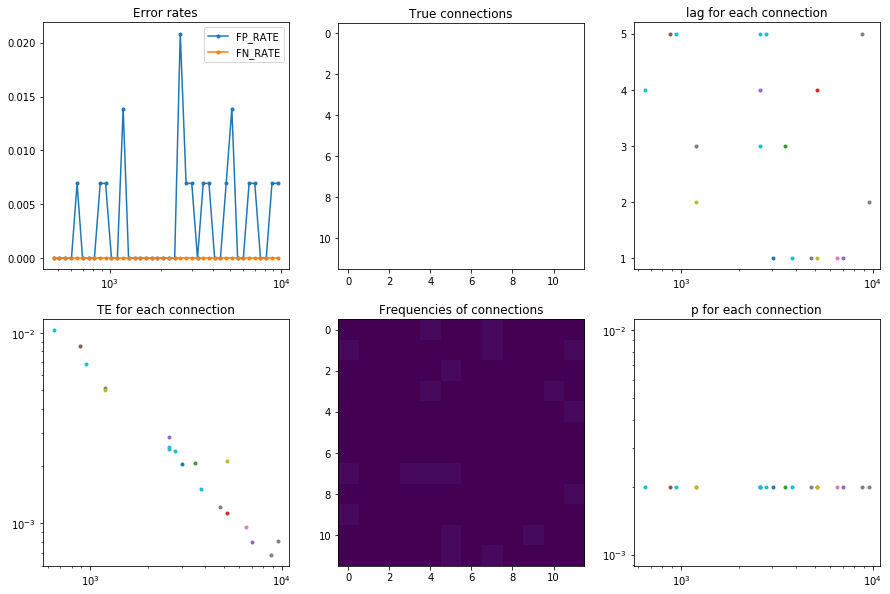

Generating Data width lpfsubnoise 79
Generating Data width lpfsubnoise 85
Generating Data width lpfsubnoise 92
Generating Data width lpfsubnoise 100
Generating Data width lpfsubnoise 108
Generating Data width lpfsubnoise 116
Generating Data width lpfsubnoise 126
Generating Data width lpfsubnoise 136
Generating Data width lpfsubnoise 147
Generating Data width lpfsubnoise 158
Generating Data width lpfsubnoise 171
Generating Data width lpfsubnoise 185
Generating Data width lpfsubnoise 200
Generating Data width lpfsubnoise 215
Generating Data width lpfsubnoise 233
Generating Data width lpfsubnoise 251
Generating Data width lpfsubnoise 271
Generating Data width lpfsubnoise 293
Generating Data width lpfsubnoise 316
Generating Data width lpfsubnoise 342
Generating Data width lpfsubnoise 369
Generating Data width lpfsubnoise 399
Generating Data width lpfsubnoise 430
Generating Data width lpfsubnoise 465
Generating Data width lpfsubnoise 502
Generating Data width lpfsubnoise 542
Generating Data

In [ ]:
%%time
#####################
# Width/Depth Analysis
#####################

N_NODE = 12  # Number of channels
N_STEP = 40  # Number of different data sizes to pick
T_STEP = idtxl_settings['max_lag_sources'] + 1   # Data quantity multiplier 
ndata_lst = (2 * 10**(np.linspace(1.6, 2.9, N_STEP))).astype(int)

idtxl_methods = ['BivariateMI', 'MultivariateMI', 'BivariateTE', 'MultivariateTE']

for analysis in ['width', 'depth']:
    for modelname, model_param in model_param_all.items():
        TRUE_CONN = TRUE_CONN_DICT[modelname]

        ###################################
        # Generate data - takes some time
        ###################################
        data_lst = []
        ndata_eff = np.zeros(N_STEP, dtype=int)
        for i, ndata in enumerate(ndata_lst):
            print("Generating Data", analysis, modelname, ndata)

            model_param['N_NODE'] = N_NODE

            if analysis == 'width':
                # Generate whole data once
                idtxl_settings['dim_order'] = 'ps'
                if 'DT' in model_param:
                    model_param['T_TOT']  = ndata * T_STEP * model_param['DT'] 
                else:
                    model_param['N_DATA'] = ndata * T_STEP
                data = model_param['method'](model_param)
                ndata_eff[i] = data.shape[1]
            else:
                # Generate each trial independently, then concatenate
                idtxl_settings['dim_order'] = 'rsp'
                if 'DT' in model_param:
                    model_param['T_TOT' ] = T_STEP * model_param['DT']
                else:
                    model_param['N_DATA'] = T_STEP

                data = np.array([model_param['method'](model_param) for j in range(ndata)]).transpose((0, 2, 1))
                ndata_eff[i] = data.shape[0]
                
            data_lst += [data]
            
        for method in idtxl_methods:
            idtxl_settings['method'] = method
            te_results = np.zeros((3, N_NODE, N_NODE, N_STEP))
            
            for i, ndata in enumerate(ndata_lst):
                print("Processing Data", analysis, method, modelname, ndata)
                
                # Run calculation
                rez = idtxlParallelCPU(data_lst[i], idtxl_settings)

                # Parse Data
                te_results[..., i] = np.array(idtxlResultsParse(rez, N_NODE, method=method, storage='matrix'))

            # Plot
            fname = modelname + '_' + str(N_NODE) + method + '_' + analysis
            testplots(ndata_eff, te_results, TRUE_CONN, logx=True, pfilter=0.01, h5_fname=fname+'.h5', fig_fname=fname+'.png')

In [ ]:
%%time
###############################
# Window / Lag / Downsampling
###############################
'''
TODO:
1) Import resampling
2) Implement stat collection
3) Implement statplots
'''

N_NODE = 12
N_TRIAL = 400
N_DATA = 200
DT = 0.05     # seconds, natural delay time

idtxl_settings['dim_order'] = 'rsp'
idtxl_methods = ['BivariateMI', 'MultivariateMI', 'BivariateTE', 'MultivariateTE']

for modelname, model_param in model_param_all.items():
    TRUE_CONN = TRUE_CONN_DICT[modelname]

    ###################################
    # Generate data - takes some time
    ###################################
    print("Generating Data", analysis, modelname)

    model_param['N_NODE'] = N_NODE
    model_param['DT'] = DT
    model_param['N_DATA'] = N_DATA
    model_param['T_TOT' ] = N_DATA * DT
    
    # Generate each trial independently, then concatenate
    data = np.array([model_param['method'](model_param) for j in range(N_TRIAL)]).transpose((0, 2, 1))
    
    ###################################
    # Window
    ###################################
    idtxl_settings['min_lag_sources'] = 1
    idtxl_settings['max_lag_sources'] = 5
    
    wlen = np.arange(2, 11)
    for method in idtxl_methods:
        stat = []
        
        for window in wlen:
            print("Processing Window Data", modelname, method)
            
            idtxl_settings['method'] = method                    
            te_results = np.zeros((3, N_NODE, N_NODE, N_DATA - window))
            
            for iTime in range(N_DATA - window):
                # Run calculation
                rez = idtxlParallelCPU(data[:, i:i+window, :], idtxl_settings)

                # Parse Data
                te_results[..., i] = np.array(idtxlResultsParse(rez, N_NODE, method=method, storage='matrix'))
                
            stat += [stat_te(te_results, pfilter=0.01)] # NCONN_MU, NCONN_SIG, T1_MU, T1_SIG, T2_MU, T2_SIG
            
        # Plot
        fname = "window_" + modelname + '_' + str(N_NODE) + method
        statplots(wlen, stat, TRUE_CONN, xlabel="window", logx=True, h5_fname=fname+'.h5', fig_fname=fname+'.png')
    
    
    ###################################
    # Lag
    ###################################
    window = 6
    idtxl_settings['min_lag_sources'] = 1
    
    maxlag_lst = np.arange(1, 6)
    for method in idtxl_methods:
        stat = []
        
        for maxlag in maxlag_lst:
            print("Processing Lag Data", modelname, method)
            
            idtxl_settings['method'] = method
            idtxl_settings['max_lag_sources'] = maxlag
            
            te_results = np.zeros((3, N_NODE, N_NODE, N_DATA - window))
            
            for iTime in range(N_DATA - window):
                # Run calculation
                rez = idtxlParallelCPU(data[:, i:i+window, :], idtxl_settings)

                # Parse Data
                te_results[..., i] = np.array(idtxlResultsParse(rez, N_NODE, method=method, storage='matrix'))
                
            stat += [stat_te(te_results, pfilter=0.01)] # NCONN_MU, NCONN_SIG, T1_MU, T1_SIG, T2_MU, T2_SIG
            
        # Plot
        fname = "lag_" + modelname + '_' + str(N_NODE) + method
        statplots(maxlag_lst, stat, TRUE_CONN, xlabel="lag", logx=True, h5_fname=fname+'.h5', fig_fname=fname+'.png')
    
    
    ###################################
    # Downsampling
    ###################################
    window = 6
    idtxl_settings['min_lag_sources'] = 1
    idtxl_settings['max_lag_sources'] = 5
    
    downsample_times = np.arange(0.1, 0.6, 0.1)
    for method in idtxl_methods:
        stat = []
        
        for dt_down in downsample_times:
            print("Processing Downsample Data", modelname, method)
            
            idtxl_settings['method'] = method
            
            # Downsample data
            times_orig = np.arange(0, model_param['T_TOT'], DT)
            times_down = np.arange(0, model_param['T_TOT'], dt_down)
            N_DATA_DOWN = len(times_down)
            data_downsampled = np.zeros((N_TRIAL, N_DATA_DOWN, N_NODE))            
            for iTr in range(N_TRIALS):
                for iNode in range(N_NODE):
                    data_downsampled[iTr, :, iNode] = resample(times_orig, data[iTr, :, iNode], times_down, param_down)
            
            te_results = np.zeros((3, N_NODE, N_NODE, N_DATA_DOWN - window))
            
            for iTime in range(N_DATA_DOWN - window):
                # Run calculation
                rez = idtxlParallelCPU(data_downsampled[:, i:i+window, :], idtxl_settings)

                # Parse Data
                te_results[..., i] = np.array(idtxlResultsParse(rez, N_NODE, method=method, storage='matrix'))
                
            stat += [stat_te(te_results, pfilter=0.01)] # NCONN_MU, NCONN_SIG, T1_MU, T1_SIG, T2_MU, T2_SIG
            
        # Plot
        fname = "lag_" + modelname + '_' + str(N_NODE) + method
        statplots(maxlag_lst, stat, TRUE_CONN, xlabel="lag", logx=True, h5_fname=fname+'.h5', fig_fname=fname+'.png')

